# Assessing the Impact of Question Ambiguity in Question-Answering Systems

**Objective:** Evaluate how effectively LLMs detect and handle ambiguity in questions and analyze the impact on system performance and output uncertainty.

# STEP 5: Evaluation with Sentence-BERT

- [SentenceBERT Paper](https://arxiv.org/pdf/1908.10084)
- [SentenceTransformers Documentation](https://www.sbert.net)
- [Pretrained Models](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html)

In [1]:
# import libraries
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
from IPython.display import display
from tqdm.notebook import tqdm
import pandas as pd
import string
import torch
import re

2025-09-19 09:02:37.159711: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758272557.341292      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758272557.394428      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>1. Load and Normalize Data</b> 
</div>

- Load the dataset with predicted models' answers
- Normalize the answers: lowercase, remove punctuation and articles, and standardize whitespace

In [2]:
# Load CSV file
df = pd.read_csv("data/model_answer_predictions_3.csv", sep=",")
df.head()

,context,target_word,question,annotated_question,answers,ground_truth_answer,bert-base_pred_orig,bert-base_pred_ambig,bert-large_pred_orig,bert-large_pred_ambig,roberta-base_pred_orig,roberta-base_pred_ambig,roberta-large_pred_orig,roberta-large_pred_ambig,deberta-base_pred_orig,deberta-base_pred_ambig,deberta-large_pred_orig,deberta-large_pred_ambig
0,Beyoncé's first solo recording was a feature o...,album,"The album, Dangerously in Love achieved what s...",What spot did the album achieve?,"{'text': ['number four'], 'answer_start': [123]}",['number four'],number four,number four,number four,NaN,four,number four,four,atop the Billboard 200,number four,four,four,atop the Billboard 200
1,Following the disbandment of Destiny's Child i...,album,"After her second solo album, what other entert...","After her second album, what other entertainme...","{'text': ['acting'], 'answer_start': [207]}",['acting'],acting,acting,acting,acting,acting,acting,acting,acting,acting,acting,acting,acting
2,Beyoncé's first solo recording was a feature o...,album,Beyonce's first album by herself was called what?,Her first album was called what?,"{'text': ['Dangerously in Love'], 'answer_star...",['Dangerously in Love'],dangerously in love,dangerously in love,dangerously in love,dangerously in love,Dangerously in Love,Dangerously in Love,Dangerously in Love,Dangerously in Love,Dangerously in Love,Dangerously in Love,Dangerously in Love,Dangerously in Love
3,Beyoncé's first solo recording was a feature o...,album,Beyonce's first solo album in the U.S. with wh...,Her first album in the U.S. featured which art...,"{'text': ['Jay Z'], 'answer_start': [48]}",['Jay Z'],jay z,jay z,jay z,jay z,Jay Z,"Jay Z's ""'03 Bonnie & Clyde"" that was release...",Jay Z,Jay Z,Jay Z,Jay Z,Jay Z,Jay Z
4,"In November 2003, she embarked on the Dangerou...",album,Destiny's Child's final album was named what?,Their final album was named what?,"{'text': ['Destiny Fulfilled'], 'answer_start'...",['Destiny Fulfilled'],destiny fulfilled,destiny fulfilled,destiny fulfilled,destiny fulfilled,Destiny Fulfilled,Destiny Fulfilled,Destiny Fulfilled,Destiny Fulfilled,Destiny Fulfilled,Destiny Fulfilled,Destiny Fulfilled,Destiny Fulfilled


In [3]:
df.columns

Index(['context', 'target_word', 'question', 'annotated_question', 'answers',
       'ground_truth_answer', 'bert-base_pred_orig', 'bert-base_pred_ambig',
       'bert-large_pred_orig', 'bert-large_pred_ambig',
       'roberta-base_pred_orig', 'roberta-base_pred_ambig',
       'roberta-large_pred_orig', 'roberta-large_pred_ambig',
       'deberta-base_pred_orig', 'deberta-base_pred_ambig',
       'deberta-large_pred_orig', 'deberta-large_pred_ambig'],
      dtype='object')

In [10]:
def normalize_answers(text):
    text = str(text).lower()
    text = re.sub(r'\b(a|an|the)\b', ' ', text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>2. Model Evaluation</b> 
</div>

- Apply 'normalize_answers' function to ground truth answers and models' predictions
- Encode predictions
- Compute cosine similarity between original vs.ground thruth (gold) and ambiguous vs.ground thruth (gold) answers

Source for [code]((https://www.sbert.net/docs/sentence_transformer/pretrained_models.html))

In [11]:
# Connect to GPU (if available)

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB


In [12]:
# Load SBERT model 
sbert_model = SentenceTransformer("all-mpnet-base-v2").to(device) 

# Define model names 
models = [
    "bert-base", 
    "bert-large", 
    "roberta-base", 
    "roberta-large", 
    "deberta-base", 
    "deberta-large"
]

# Store the results
results = []

# Loop over each row in the dataset
for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing", leave=True):
    
    gold = normalize_answers(row["ground_truth_answer"])
    gold_emb = sbert_model.encode(gold, convert_to_tensor=True, show_progress_bar=False)

    
    for model in models:
        
        # Normalize predictions
        pred_orig = normalize_answers(row[f"{model}_pred_orig"])
        pred_ambig = normalize_answers(row[f"{model}_pred_ambig"])
        
        # Encode predictions
        pred_orig_emb = sbert_model.encode(pred_orig, convert_to_tensor=True, show_progress_bar=False)
        pred_ambig_emb = sbert_model.encode(pred_ambig, convert_to_tensor=True, show_progress_bar=False)
        

        # Compute cosine similarities
        cs_orig_gold = util.cos_sim(pred_orig_emb, gold_emb).item()
        cs_ambig_gold = util.cos_sim(pred_ambig_emb, gold_emb).item()

        
        # Store results
        results.append({
            "model": model,
            "cs_orig_gold": cs_orig_gold,
            "cs_ambig_gold": cs_ambig_gold
        })

# Convert to DataFrame
cs_df = pd.DataFrame(results)

# Compute average similarities per model
cs_summary = (
    cs_df.groupby("model")[["cs_orig_gold", "cs_ambig_gold"]].mean().round(2).reset_index())

# Display the summary
display(cs_summary)

Processing:   0%|          | 0/1265 [00:00<?, ?it/s]

,model,cs_orig_gold,cs_ambig_gold
0,bert-base,0.95,0.79
1,bert-large,0.95,0.86
2,deberta-base,0.99,0.80
3,deberta-large,0.97,0.78
4,roberta-base,0.92,0.77
5,roberta-large,0.98,0.77


In [13]:
# Compute the drop in cosine similarity between orig and ambig answers
cs_summary["delta"] = (cs_summary["cs_orig_gold"] - cs_summary["cs_ambig_gold"]).round(2)
cs_summary

,model,cs_orig_gold,cs_ambig_gold,delta
0,bert-base,0.95,0.79,0.16
1,bert-large,0.95,0.86,0.09
2,deberta-base,0.99,0.80,0.19
3,deberta-large,0.97,0.78,0.19
4,roberta-base,0.92,0.77,0.15
5,roberta-large,0.98,0.77,0.21


In [14]:
cs_df

,model,cs_orig_gold,cs_ambig_gold
0,bert-base,1.000000,1.000000
1,bert-large,1.000000,0.160909
2,roberta-base,0.640472,1.000000
3,roberta-large,0.640472,0.225876
4,deberta-base,1.000000,0.640472
...,...,...,...
7585,bert-large,1.000000,1.000000
7586,roberta-base,1.000000,1.000000
7587,roberta-large,1.000000,1.000000
7588,deberta-base,1.000000,1.000000


In [15]:
# Save results
cs_df.to_csv("data/sbert_cs_rows_all_5.csv", index=False)

In [16]:
# Save results
cs_summary.to_csv("data/sbert_cs_summary_all_5.csv", index=False)

In [17]:
pred_orig_emb.shape

torch.Size([768])

In [18]:
pred_ambig_emb.shape

torch.Size([768])

In [19]:
pred_orig_emb[:10]

tensor([ 0.0165, -0.0073, -0.0380,  0.0270, -0.0247, -0.0407,  0.0310, -0.0380,
        -0.0108,  0.0469], device='cuda:0')

In [20]:
pred_ambig_emb[:10]

tensor([ 0.0165, -0.0073, -0.0380,  0.0270, -0.0247, -0.0407,  0.0310, -0.0380,
        -0.0108,  0.0469], device='cuda:0')

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>3. Plotting the Results</b> 
</div>

- The plotting of scatterplots was made with the help of 'gpt-4o' model.

In [21]:
cs_df.columns.tolist()

['model', 'cs_orig_gold', 'cs_ambig_gold']

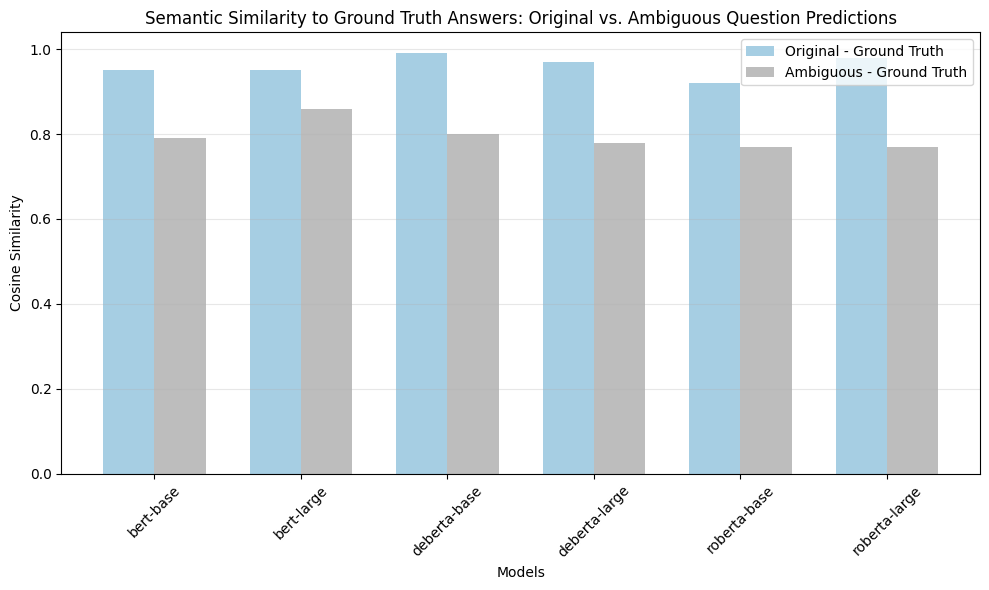

In [23]:
models = cs_summary["model"]
orig = cs_summary["cs_orig_gold"]
ambig = cs_summary["cs_ambig_gold"]

x = range(len(models))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x, orig, width=width, label="Original - Ground Truth", color="#a6cee3")
plt.bar([i + width for i in x], ambig, width=width, label="Ambiguous - Ground Truth", color="#bdbdbd")

plt.xticks([i + width/2 for i in x], models, rotation=45)
plt.xlabel("Models")
plt.ylabel("Cosine Similarity")
plt.title("Semantic Similarity to Ground Truth Answers: Original vs. Ambiguous Question Predictions")
plt.legend()
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
  
plt.savefig("figures/cs_orig_amb_barplot_5.png", dpi=300)  

plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

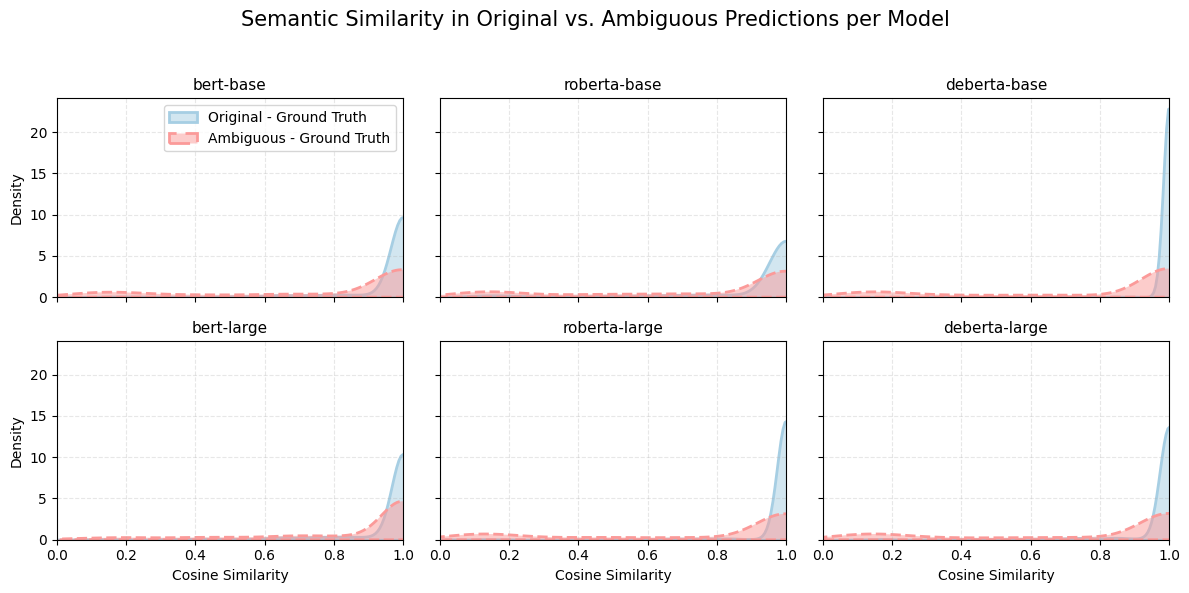

In [25]:
import seaborn as sns

# Pastel tone colors 
orig_color = "#a6cee3"   # Light blue
ambig_color = "#fb9a99"  # Light red

# Models
base_models = ["bert-base", "roberta-base", "deberta-base"]
large_models = ["bert-large", "roberta-large", "deberta-large"]

fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)
axes = axes.flatten()

# Top row: base models
for i, model in enumerate(base_models):
    subset = cs_df[cs_df["model"] == model]
    ax = axes[i]
    sns.kdeplot(subset["cs_orig_gold"], ax=ax, label="Original - Ground Truth", fill=True, color=orig_color, alpha=0.5, linewidth=2)
    sns.kdeplot(subset["cs_ambig_gold"], ax=ax, label="Ambiguous - Ground Truth", fill=True, color=ambig_color, alpha=0.5, linewidth=2, linestyle="--")
    ax.set_title(f"{model}", fontsize=11)
    ax.set_xlim(0, 1)
    ax.grid(True, linestyle="--", alpha=0.3)

# Bottom row: large models
for i, model in enumerate(large_models):
    subset = cs_df[cs_df["model"] == model]
    ax = axes[i + 3]
    sns.kdeplot(subset["cs_orig_gold"], ax=ax, fill=True, color=orig_color, alpha=0.5, linewidth=2)
    sns.kdeplot(subset["cs_ambig_gold"], ax=ax, fill=True, color=ambig_color, alpha=0.5, linewidth=2, linestyle="--")
    ax.set_title(f"{model}", fontsize=11)
    ax.set_xlim(0, 1)
    ax.grid(True, linestyle="--", alpha=0.3)
    

# Axis labels
for ax in axes[3:]:
    ax.set_xlabel("Cosine Similarity")

axes[0].set_ylabel("Density")
axes[3].set_ylabel("Density")

axes[0].legend(loc="upper right", fontsize=10)

# Title
plt.suptitle("Semantic Similarity in Original vs. Ambiguous Predictions per Model", fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.95])
  
plt.savefig("figures/cs_all_kdeplot_5.png", dpi=300) 

plt.show()
